#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/kt aivle/3차 미니 프로젝트/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [38]:
# 데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/kt aivle/3차 미니 프로젝트/data01_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/kt aivle/3차 미니 프로젝트/data01_test.csv')
feature = pd.read_csv('/content/drive/MyDrive/kt aivle/3차 미니 프로젝트/features.csv')

In [6]:
# 불필요 칼럼 삭제
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [7]:
# 데이터 형태
train_data.shape, test_data.shape

((5881, 562), (1471, 562))

In [8]:
#데이터 정보
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB


(None, None)

In [9]:
# 데이터 기초통계량
train_data.describe(), test_data.describe()

(       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
 count        5881.000000        5881.000000        5881.000000   
 mean            0.274811          -0.017799          -0.109396   
 std             0.067614           0.039422           0.058373   
 min            -0.503823          -0.684893          -1.000000   
 25%             0.262919          -0.024877          -0.121051   
 50%             0.277154          -0.017221          -0.108781   
 75%             0.288526          -0.010920          -0.098163   
 max             1.000000           1.000000           1.000000   
 
        tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
 count       5881.000000       5881.000000       5881.000000       5881.000000   
 mean          -0.603138         -0.509815         -0.604058         -0.628151   
 std            0.448807          0.501815          0.417319          0.424345   
 min           -1.000000         -0.999844         -0.999667       

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [10]:
# 범주의 종류
train_data['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [11]:
# 범주별 빈도수
train_data['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [12]:
# 범주별 비율
train_data['Activity'].value_counts(normalize=True)

,proportion
Activity,
LAYING,0.189594
STANDING,0.184833
SITTING,0.175480
WALKING,0.169699
WALKING_UPSTAIRS,0.145894
WALKING_DOWNSTAIRS,0.134501


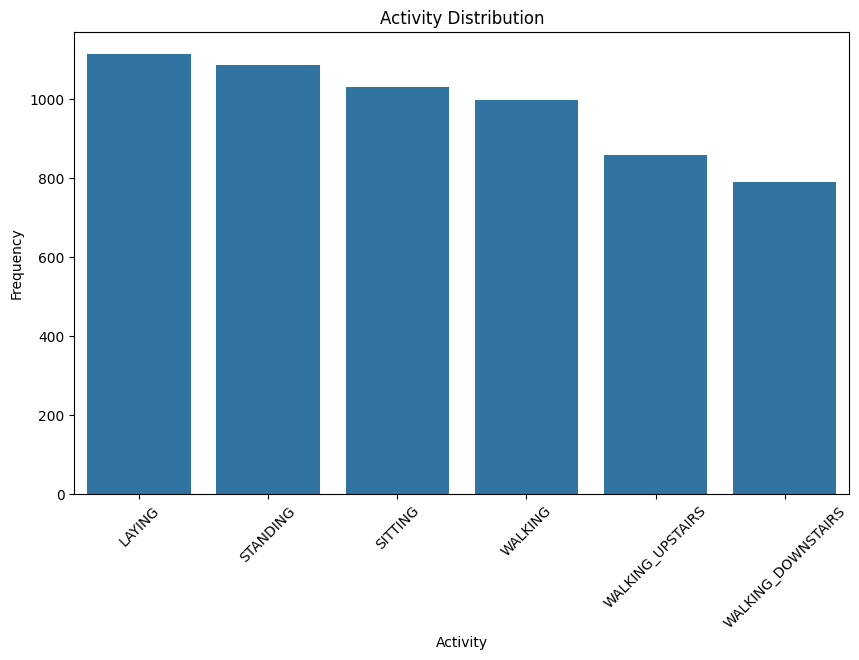

In [13]:
# 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Activity', order=train_data['Activity'].value_counts().index)
plt.title('Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [14]:
target = 'Activity'

x = train_data.drop(target, axis = 1)
y = train_data.loc[:, target]

In [15]:
# 데이터 분할
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 42)

#### 2) 모델링

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 랜덤 포레스트 모델 생성
model = RandomForestClassifier()

# 모델 훈련
model.fit(x_train, y_train)

# 검증 세트에서 예측 수행
y_pred = model.predict(x_val)

# 검증 세트에서 성능 평가
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

Validation Accuracy: 0.98


#### 3) 변수 중요도 추출

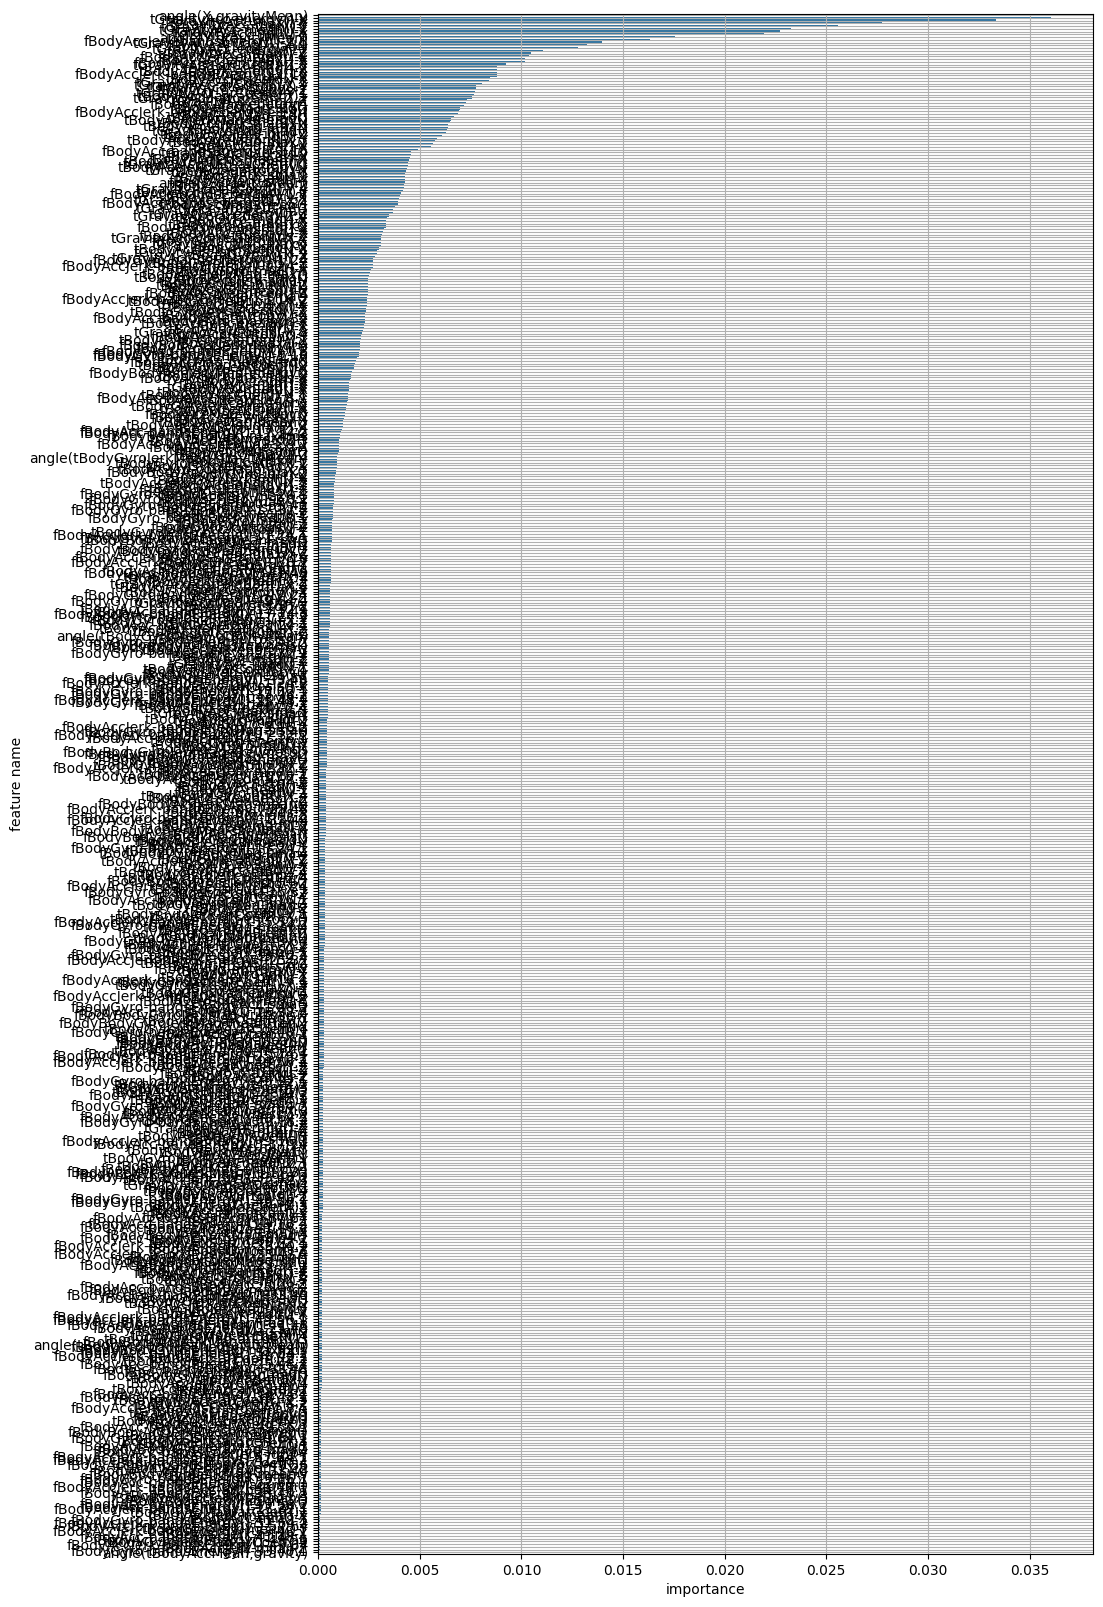

In [17]:
# 모델 훈련 후 변수 중요도 추출
importance = model.feature_importances_
names = x_train.columns

result = plot_feature_importance(importance, names)
plt.show()

In [18]:
result

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.036316
1,tGravityAcc-energy()-X,0.036078
2,tGravityAcc-max()-X,0.033328
3,tGravityAcc-max()-Y,0.027722
4,tGravityAcc-mean()-Y,0.025577
...,...,...
556,tBodyGyroJerkMag-arCoeff()2,0.000093
557,"fBodyAccJerk-bandsEnergy()-49,64",0.000090
558,fBodyAccJerk-min()-Z,0.000076
559,"fBodyGyro-bandsEnergy()-33,40.1",0.000069


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [19]:
# 상위: angle(X,gravityMean), tGravityAcc-mean()-X, tGravityAcc-mean()-Y, tGravityAcc-max()-X, tGravityAcc-max()-Y

In [20]:
# 하위: fBodyAcc-bandsEnergy()-57,64.1, tBodyAccJerk-mean()-Z, fBodyAccJerk-iqr()-Z, fBodyBodyAccJerkMag-entropy(), fBodyAccJerk-bandsEnergy()-33,40.1

In [21]:
# 상위
# angle(X,gravityMean): (X축 방향 - 중력가속도 평균) 벡터 사이의 각도
# tGravityAcc-mean()-X: X축 방향 중력가속도 평균
# tGravityAcc-mean()-Y: Y축 방향 중력가속도 평균
# tGravityAcc-max()-X: X축 방향 중력가속도 최대값
# tGravityAcc-max()-Y: Y축 방향 중력가속도 최대값

# 하위
# fBodyAcc-bandsEnergy()-57,64.1: 고속퓨리에변환을 거친 57~64 구간의 시간갭1에 대한  에너지 밴드 가속도
# tBodyAccJerk-mean()-Z: Z축 방향 가속도변화비율 평균
# fBodyAccJerk-iqr()-Z: 고속퓨리에변환을 거친 Z축 방향 가속도변화비율 3사분위수 - 1사분위수
# fBodyBodyAccJerkMag: 유클리드 노름을 사용한 고속퓨리에변환을 거친 가속도변화비율 3차원 신호 크기 신호의 엔트로피
# fBodyAccJerk-bandsEnergy()-33,40.1: 고속퓨리에변환을 거친 33~40 구간의 시간갭1에  대한 에너지 밴드 가속도 변화비율

#### 2) 상위 5개 변수에 대한 분석

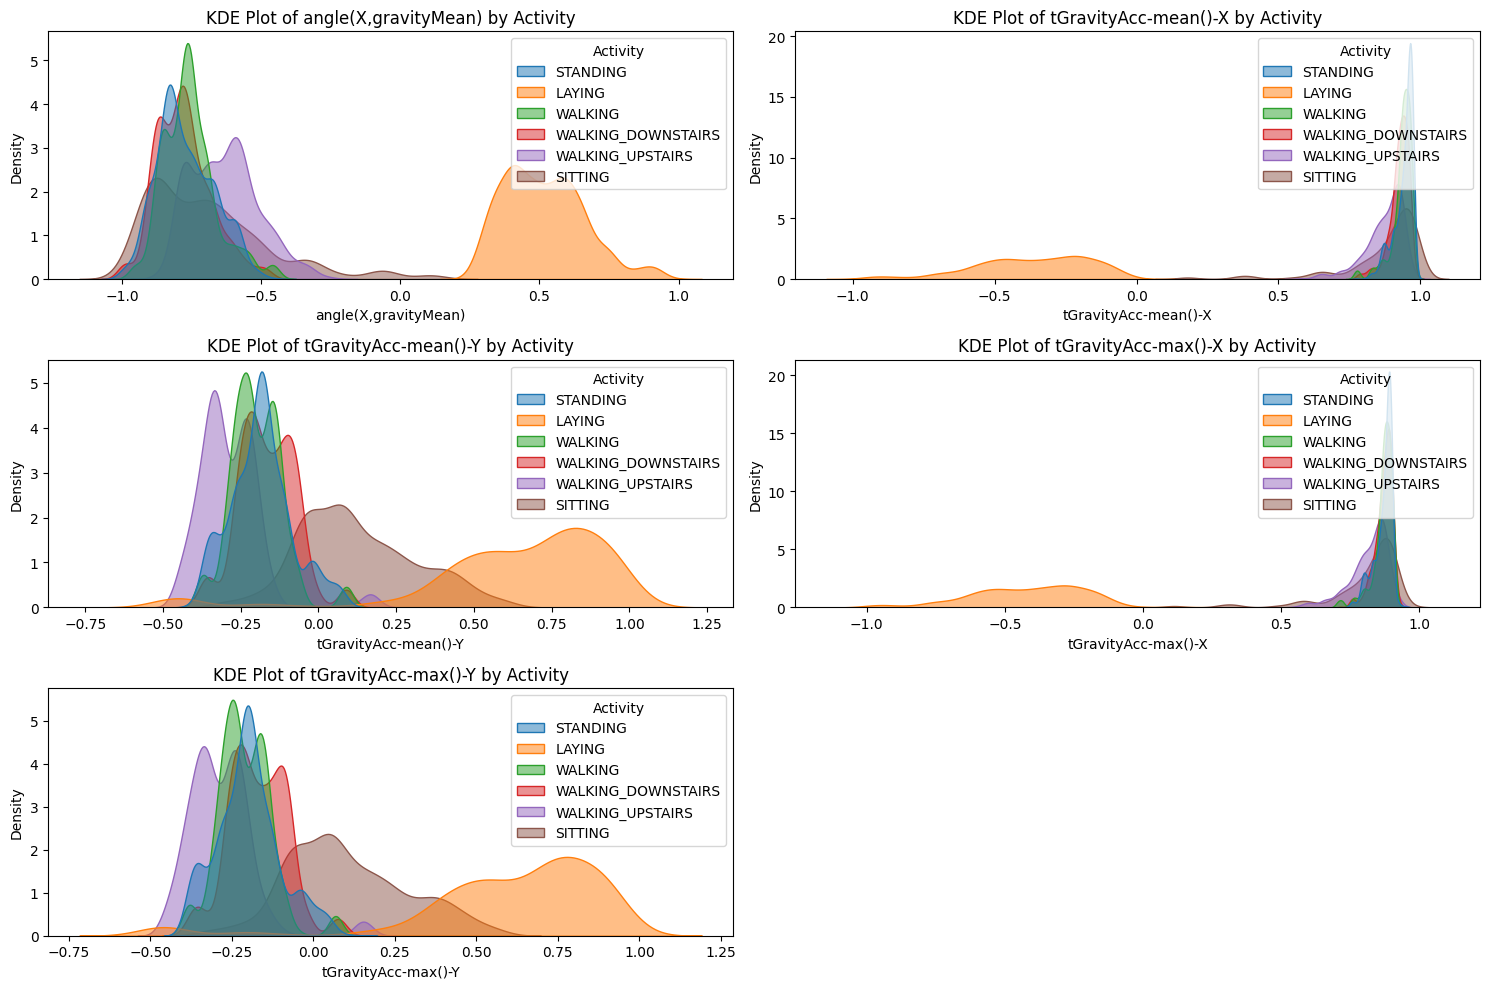

In [22]:
# 상위 5개 변수 목록
top_5_features = ['angle(X,gravityMean)','tGravityAcc-mean()-X','tGravityAcc-mean()-Y',
                  'tGravityAcc-max()-X', 'tGravityAcc-max()-Y']

# 타겟 변수 설정
target = 'Activity'

# KDE 플롯 그리기
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_5_features):
    plt.subplot(3, 2, i + 1)  # 3행 2열 서브플롯 생성
    sns.kdeplot(data=train_data, x=feature, hue=target, common_norm=False, fill=True, alpha=0.5)
    plt.title(f'KDE Plot of {feature} by {target}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### 3) 하위 5개 변수에 대한 분석

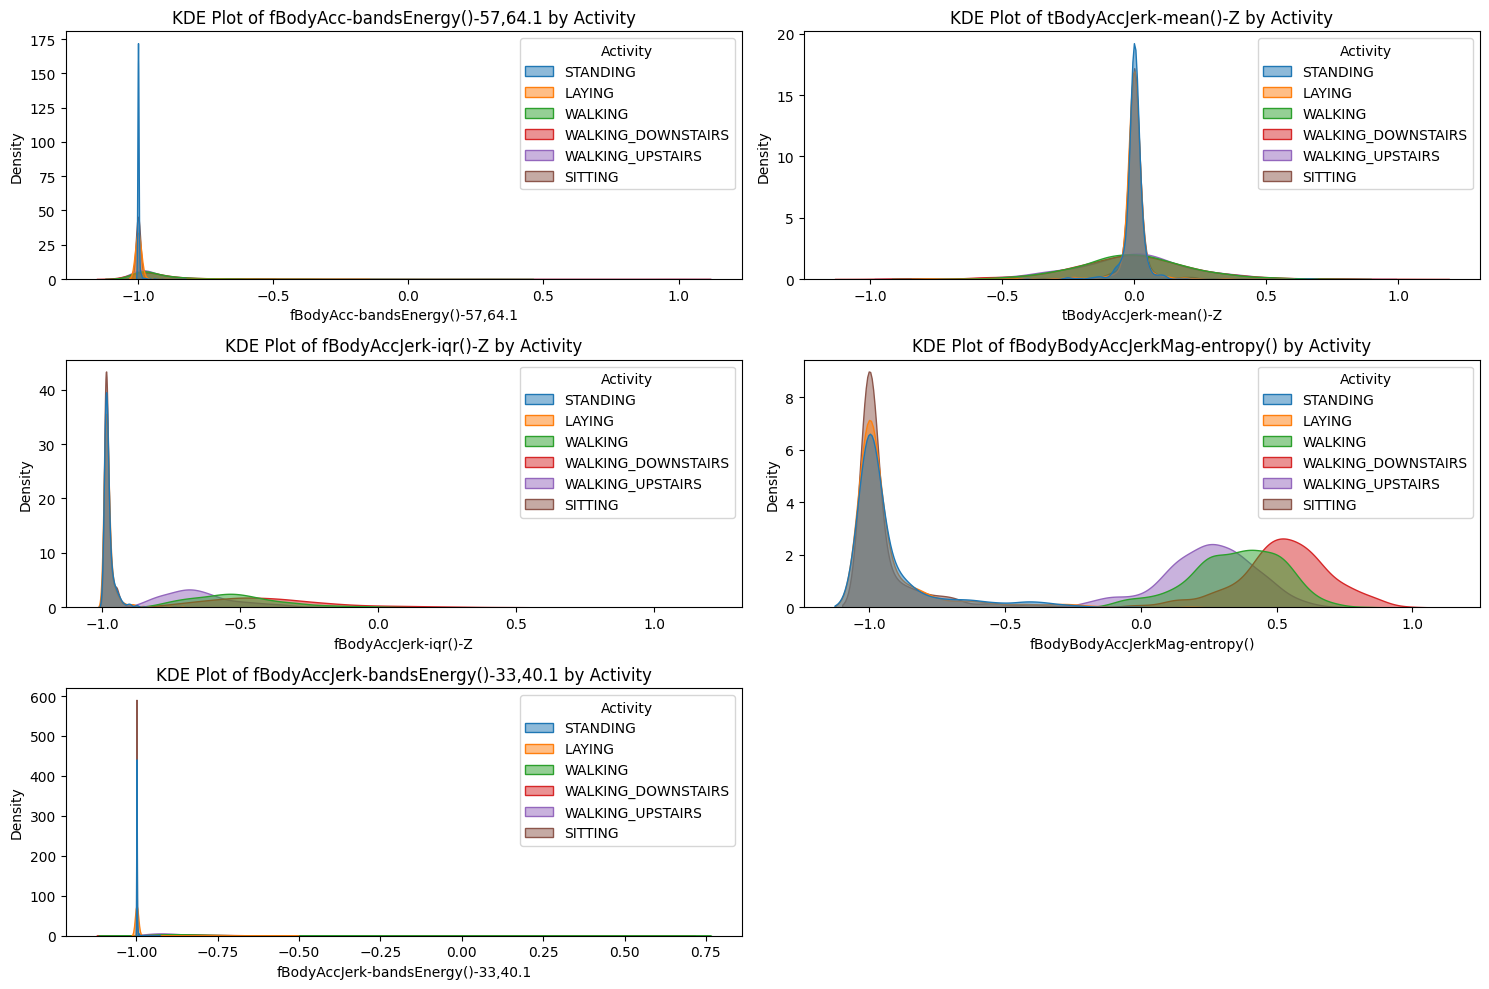

In [23]:
# 하위 5개 변수 목록
bottom_5_features = [
    'fBodyAcc-bandsEnergy()-57,64.1', 'tBodyAccJerk-mean()-Z',
    'fBodyAccJerk-iqr()-Z', 'fBodyBodyAccJerkMag-entropy()', 'fBodyAccJerk-bandsEnergy()-33,40.1']

# KDE 플롯 그리기
plt.figure(figsize=(15, 10))

for i, feature in enumerate(bottom_5_features):
    plt.subplot(3, 2, i + 1)  # 3행 2열 서브플롯 생성
    sns.kdeplot(data=train_data, x=feature, hue='Activity', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'KDE Plot of {feature} by Activity')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [24]:
# Activity를 is_dynamic으로 변환
activity_mapping = {
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

# Activity를 is_dynamic으로 변환하고 Activity 열 삭제
train_data['is_dynamic'] = train_data['Activity'].map(activity_mapping)
train_data.drop('Activity', axis=1, inplace=True)  # Activity 열 삭제

In [25]:
train_data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,1


#### 2) 기본모델 생성

In [26]:
target = 'is_dynamic'
x = train_data.drop(target, axis=1)
y = train_data.loc[:, target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create and train the model
model2 = RandomForestClassifier(random_state=42)
model2.fit(x_train, y_train)

# Make predictions
y_pred2 = model2.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred2))
print(f"Accuracy: {accuracy_score(y_val, y_pred2)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

Accuracy: 0.9991503823279524


#### 3) 변수중요도 상위 5개 분석

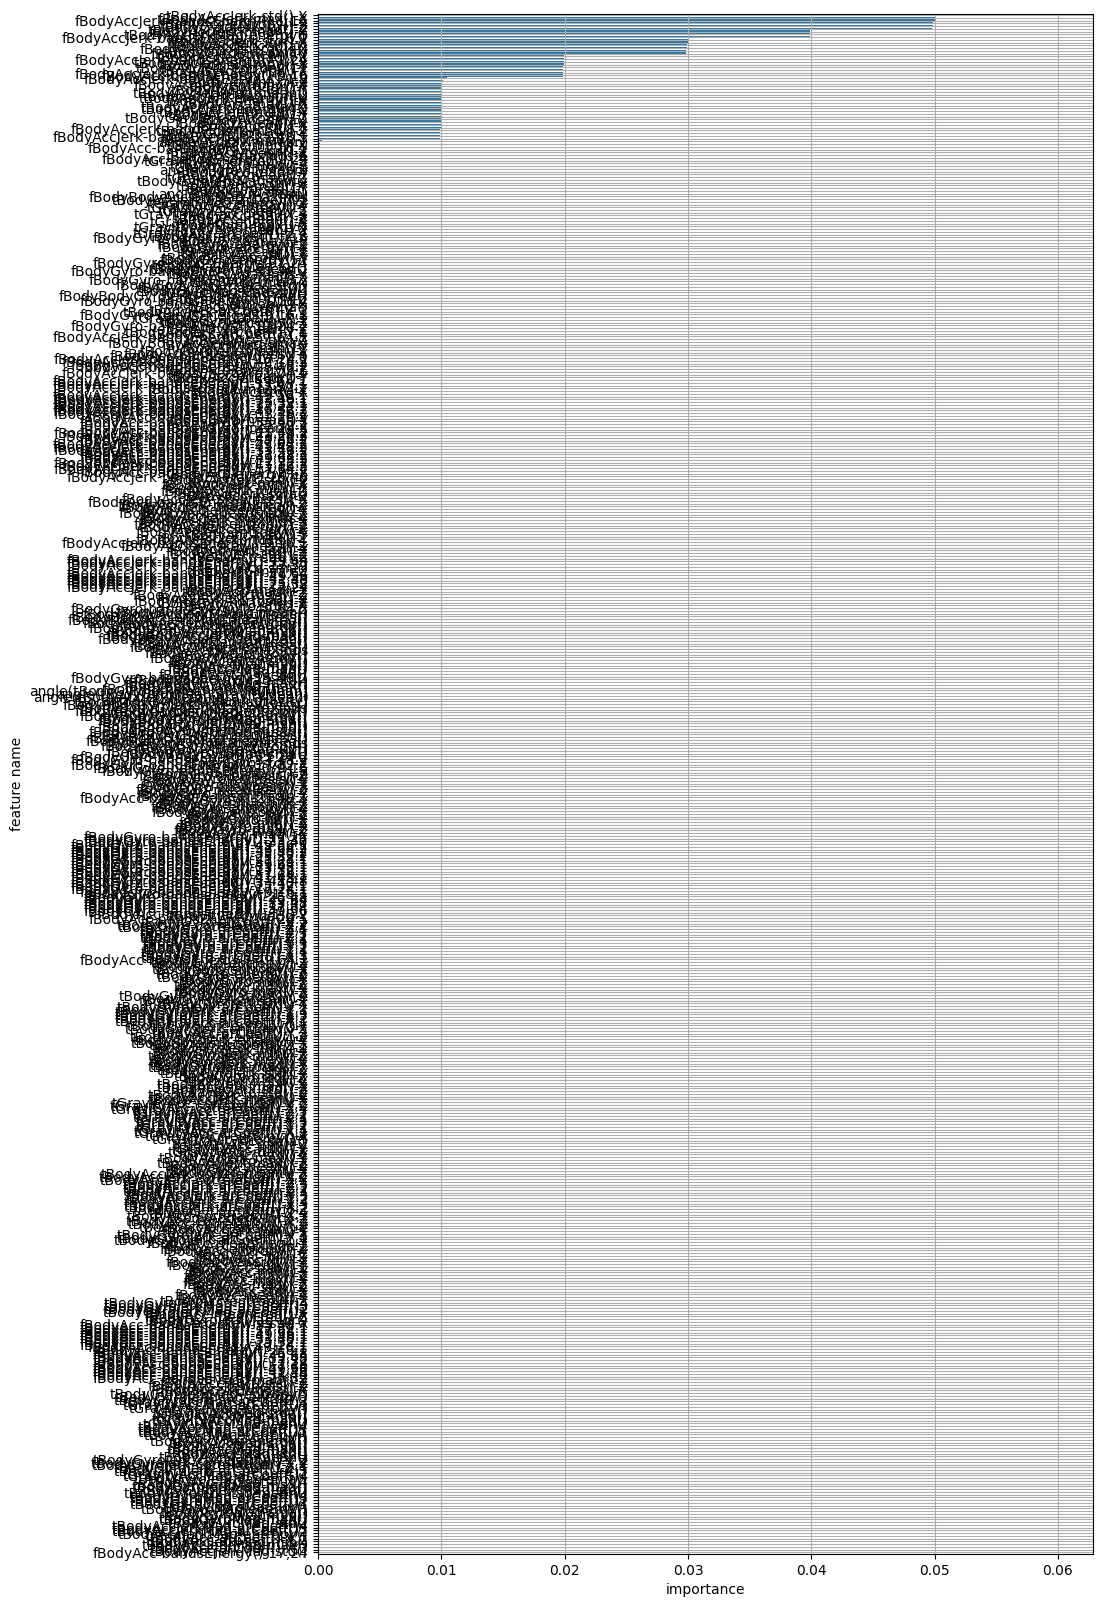

In [28]:
# 모델 훈련 후 변수 중요도 추출
importance = model2.feature_importances_
names = x_train.columns

result2 = plot_feature_importance(importance, names)
plt.show()

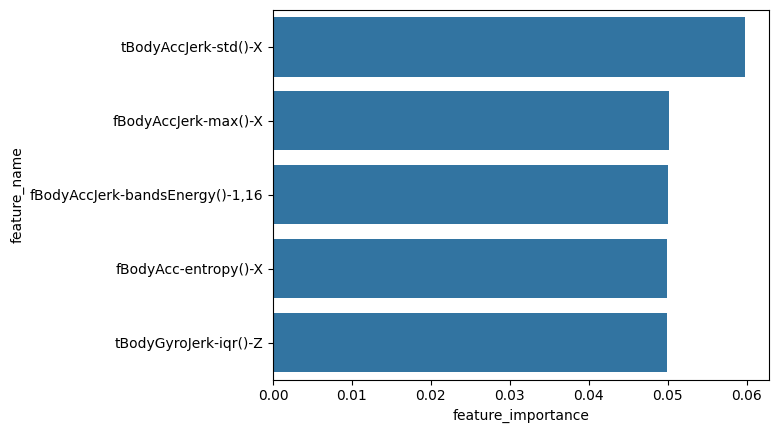

In [29]:
sns.barplot(data=result2[:5], x='feature_importance', y='feature_name')
plt.show()

In [30]:
result2['feature_name'][:5]
# tBodyAccJerk-std()-X: X축 방향 가속도변화비율 표준편차
#	fBodyAccJerk-bandsEnergy()-1,16: 고속퓨리에변환을 거친 1~16 구간의 에너지 밴드 가속도 변화비율
# fBodyAccJerk-max()-X: 고속퓨리에변환을 거친 X축 방향 가속도변화비율 최대값
# fBodyAccJerk-bandsEnergy()-1,24: 고속퓨리에변환을 거친 1~24 구간의 에너지 밴드 가속도 변화비율
# tBodyGyroJerk-iqr()-Z: Z축 방향 각속도변화속도 3사분위수 - 1사분위수

,feature_name
0,tBodyAccJerk-std()-X
1,fBodyAccJerk-max()-X
2,"fBodyAccJerk-bandsEnergy()-1,16"
3,fBodyAcc-entropy()-X
4,tBodyGyroJerk-iqr()-Z


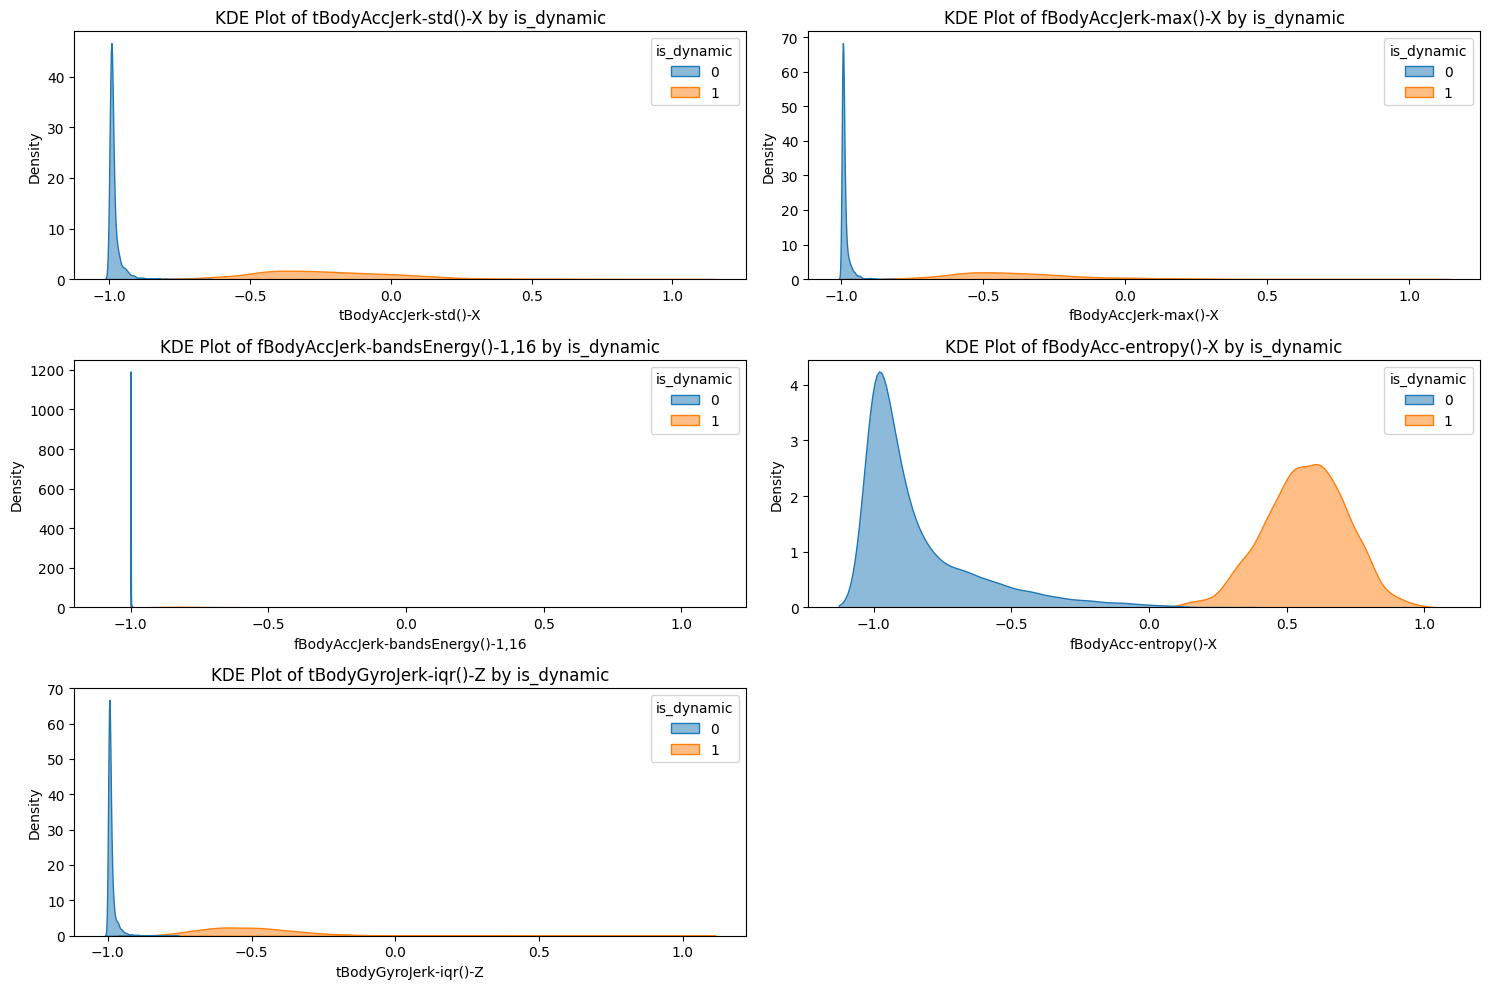

In [31]:
# 상위 5개 변수 목록
top_5_features = result2['feature_name'][:5]  # feature_name 컬럼에서 상위 5개 변수 가져오기

# 타겟 변수 설정
target = 'is_dynamic'  # 'Activity' 대신 'is_dynamic' 사용

# KDE 플롯 그리기
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_5_features):
    plt.subplot(3, 2, i + 1)  # 3행 2열 서브플롯 생성
    sns.kdeplot(data=train_data, x=feature, hue='is_dynamic', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'KDE Plot of {feature} by is_dynamic')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### 4) 변수그룹중요도 분석

In [37]:
print(type(feature))
print(type(result2))


<class 'str'>
<class 'pandas.core.frame.DataFrame'>


In [39]:
mergedata = feature.merge(result2, on='feature_name', how='left')
mergedata

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000094
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000060
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000026
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.000000
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.000040
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.000060


In [40]:
sensor_importance = mergedata.groupby('sensor')['feature_importance'].mean().sort_values(ascending=False)
print(sensor_importance)

sensor
tBodyAccJerk            5.483380e-03
tBodyAccJerkMag         5.374482e-03
fBodyAccJerk            5.058114e-03
tBodyGyroJerk           4.230324e-03
fBodyAcc                1.517107e-03
tBodyAcc                2.603381e-04
tBodyGyro               2.558061e-04
angle                   5.347934e-05
tGravityAcc             1.629636e-05
fBodyBodyAccJerkMag     4.102477e-06
tBodyGyroJerkMag        3.942315e-06
fBodyGyro               3.636658e-06
tGravityAccMag          2.640232e-06
tBodyGyroMag            1.975747e-06
tBodyAccMag             6.622646e-07
fBodyBodyGyroJerkMag    6.615725e-07
fBodyBodyGyroMag        0.000000e+00
fBodyAccMag             0.000000e+00
Name: feature_importance, dtype: float64


In [41]:
pd.set_option('display.max_rows', None)

sensor_agg_importance = mergedata.groupby(['sensor', 'agg'])['feature_importance'].mean().sort_values(ascending=False)
print(sensor_agg_importance)

sensor                agg              
tBodyAccJerkMag       energy()             3.989365e-02
tBodyAccJerk          sma()                2.993155e-02
tBodyGyroJerk         sma()                2.985441e-02
                      iqr()                2.654640e-02
tBodyAccJerk          std()                2.327339e-02
fBodyAccJerk          mean()               2.324205e-02
                      max()                1.999695e-02
fBodyAcc              entropy()            1.662958e-02
tBodyGyroJerk         mad()                1.658968e-02
tBodyAccJerk          iqr()                1.332319e-02
fBodyAccJerk          mad()                1.329454e-02
tBodyAccJerk          entropy()            1.326478e-02
fBodyAccJerk          std()                1.003703e-02
tBodyAccJerkMag       mean()               9.982839e-03
                      sma()                9.974454e-03
                      mad()                9.965824e-03
fBodyAccJerk          energy()             9.962855e-03
fBodyAcc